In [1]:
import os
import torch

os.environ["CUDA_VISIBLE_DEVICES"] = "2" 
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")  
print(f"Using device: {device}")

Using device: cuda:2


In [2]:
import pickle

with open('/home/gdlteam3/all_abbasid_poems.pkl', 'rb') as file:
    data = pickle.load(file)

In [6]:
import numpy as np
import pandas as pd
from datasets import Dataset
from tqdm.auto import tqdm  # This auto-detects the environment (Jupyter/Terminal)


# Convert numpy array to DataFrame with column name "text"
df_data = pd.DataFrame(data, columns=["text"])
df_data = df_data.sample(n=5000, random_state=42)  
dataset = Dataset.from_pandas(df_data)

# Split into 80% train / 20% validation
split_dataset = dataset.train_test_split(test_size=0.2, seed=42)

train_dataset = split_dataset['train']
val_dataset = split_dataset['test']

In [7]:
# -*- coding: utf-8 -*-

import torch
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

model_path = "UBC-NLP/AraT5v2-base-1024"

# Initialize the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)


In [8]:
from transformers import DataCollatorForLanguageModeling, DataCollatorWithPadding

# Tokenize the text data (batch tokenization)
def tokenize_function(examples):
    instruction = ["ÿßŸÉÿ™ÿ® ŸÇÿµŸäÿØÿ© ÿπÿ®ÿßÿ≥Ÿäÿ©:" for _ in examples["text"]]
    model_inputs = tokenizer(instruction, truncation=True, padding="max_length", max_length=512)
    
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            examples["text"],
            padding="max_length",
            truncation=True,
            max_length=512,
        )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

# Apply the tokenizer to the training and validation datasets
tokenized_train = train_dataset.map(tokenize_function, batched=True, remove_columns=["text"])
tokenized_val = val_dataset.map(tokenize_function, batched=True, remove_columns=["text"])

Map:   0%|          | 0/4000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [9]:
from transformers import Seq2SeqTrainingArguments, Seq2SeqTrainer, DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(tokenizer, model, label_pad_token_id=-100)

args = Seq2SeqTrainingArguments(
    output_dir="arat5-finetuned",
    num_train_epochs=5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=3e-5,
    predict_with_generate=True,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    generation_max_length=256,
    load_best_model_at_end=True,
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    data_collator=data_collator,
)


/home/gdlteam3/anaconda3/envs/arat5/lib/python3.13/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of ü§ó Transformers. Use `eval_strategy` instead
  warnings.warn(


In [10]:
trainer.train()

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


TrainOutput(global_step=2500, training_loss=2.9815122802734373, metrics={'train_runtime': 1690.4472, 'train_samples_per_second': 11.831, 'train_steps_per_second': 1.479, 'total_flos': 1.737942368256e+16, 'train_loss': 2.9815122802734373, 'epoch': 5.0})

In [28]:
model.save_pretrained("./arat5_finetuned")
tokenizer.save_pretrained("./arat5_finetuned")

('./arat5_finetuned/tokenizer_config.json',
 './arat5_finetuned/special_tokens_map.json',
 './arat5_finetuned/spiece.model',
 './arat5_finetuned/added_tokens.json',
 './arat5_finetuned/tokenizer.json')

In [21]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Load the saved model and tokenizer
model_path = "./arat5_finetuned"
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Move model to the appropriate device (GPU if available)
device = "cpu"
model = model.to(device)

In [16]:
import torch
model.eval()  # Set model to evaluation mode

def generate_poem(prompt, max_len=200):
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    outputs = model.generate(
        **inputs,
        max_length=max_len,
        do_sample=True,         
        top_p=0.9,
        temperature=0.9,
        repetition_penalty=1.1,
        no_repeat_ngram_size=4,
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Generate a poem with a given prompt
prompt = "ÿßŸÉÿ™ÿ® ŸÇÿµŸäÿØÿ© ÿπÿ®ÿßÿ≥Ÿäÿ© ÿπŸÜ ÿßŸÑÿ≠ÿ® ŸàÿßŸÑÿ≠ŸÜŸäŸÜ ÿ•ŸÑŸâ ÿ®ÿ∫ÿØÿßÿØ:"
print(generate_poem(prompt))


ŸÇŸéÿØ ÿ≠ŸèŸÅÿ±Ÿéÿ™ ÿ•ŸêŸÑŸâ ÿßŸÑÿ¥Ÿéÿ±ÿ®Ÿê ÿ®ŸêÿßŸÑÿµŸéÿ®ÿßÿ®Ÿê. ŸàŸéŸÖŸéŸÜ ÿπŸèŸÇŸêÿ®Ÿéÿ™ ŸÖŸêŸÜ ŸÜŸéŸÅÿ≥Ÿç ŸÑŸéŸÖ ŸäŸéÿ∂ÿ±Ÿêÿ®. ÿµŸéŸäÿ®ÿßŸã ŸÑŸêŸÑÿÆŸèÿ®Ÿí ÿ®ŸêŸáÿß. ŸÅŸéŸÖÿß ÿ£ŸéŸà ÿßŸêÿ≥ÿ™Ÿèÿ∑Ÿéÿ®ŸëŸè ÿ®ŸèŸäÿßŸáŸè. ŸÅŸéŸÖÿß ÿßŸêÿ≥ÿ™ŸéÿπŸéÿØŸéÿ™Ÿí ÿ•ŸêŸÜ ÿ£Ÿèÿ¨ŸéŸÑŸëŸäÿ™Ÿé ÿ£ŸéŸÜ ÿ™ŸèÿØŸèÿ±ŸëŸé ŸÅŸä ÿßŸÑÿ®ŸéŸäŸÜŸê . ŸÅŸéŸÑŸéŸÖ ÿ™Ÿéÿ∫ŸíŸÅŸéÿ±Ÿè ŸáŸéŸàŸâ ÿßŸÑÿ£Ÿéÿ≠ŸàÿßŸÑŸê ŸÖŸêŸÜ ÿ≤ŸéŸÖÿßŸÜŸêŸáŸê ÿßŸÑŸÖŸèÿ≠Ÿéÿ±ŸëŸéŸÖŸè. ŸàŸéÿ•Ÿêÿ∞ÿß ŸÖŸéÿß ÿÆŸéÿ∑ŸéŸäÿ®ŸèŸáŸè ŸàŸéÿßŸÑŸÖŸèÿ™Ÿéÿ∑ŸäŸÑŸèŸáŸè. ŸàŸéÿ±ŸéŸÇŸéŸÑŸäŸÑŸå ŸàŸéŸÑÿß ŸäŸéŸäŸÜŸê ÿßŸÑÿØŸéŸáÿ±Ÿéÿ©Ÿê ÿßŸÑŸÇŸèŸÜÿØŸéŸáŸè. ŸàŸéÿ™Ÿéÿ≤ŸéŸàÿ™Ÿé ŸäŸéŸäÿ±ŸéŸáŸèŸÖŸëŸâ ÿ≥ŸéŸÑŸäŸáŸê. ŸÑŸêŸÅÿ∏ŸéŸäŸáŸè ÿπŸéŸÜŸëŸêŸä ÿπŸèŸÜŸä. ŸàŸéÿßŸÑŸÜŸéŸÅŸéÿπÿ´ŸêŸäÿßÿ±ŸêŸáÿß ÿØŸéŸäŸÜŸê. ŸÉŸéÿ£ŸéŸÜŸëŸéŸáÿß ÿ∫ŸéŸáÿ±Ÿê ÿπ


In [30]:
prompts = [
    "ÿßŸÉÿ™ÿ® ŸÇÿµŸäÿØÿ© ÿπŸÜ ÿßŸÑÿ¥ÿ¨ÿßÿπÿ© ŸÅŸä ÿ≥ÿßÿ≠ÿßÿ™ ÿßŸÑŸÇÿ™ÿßŸÑ:",
    "ÿßŸÉÿ™ÿ® ŸÇÿµŸäÿØÿ© ÿπŸÜ ÿ¨ŸÖÿßŸÑ ÿßŸÑŸÜÿÆŸäŸÑ ÿπŸÑŸâ ÿ∂ŸÅÿßŸÅ ÿØÿ¨ŸÑÿ©:",
    "ÿßŸÉÿ™ÿ® ŸÇÿµŸäÿØÿ© ÿπŸÜ ÿßŸÑÿ≠ÿ® ŸàÿßŸÑÿ≠ŸÜŸäŸÜ ÿ•ŸÑŸâ ÿ®ÿ∫ÿØÿßÿØ:",
    "ÿßŸÉÿ™ÿ® ŸÇÿµŸäÿØÿ© ÿπŸÑŸâ ÿ®ÿ≠ÿ± ÿßŸÑŸÉÿßŸÖŸÑ ŸÅŸä ŸÖÿØÿ≠ ÿßŸÑÿπŸÑŸÖ:",
    "ÿßŸÉÿ™ÿ® ŸÇÿµŸäÿØÿ© ŸÖŸÜ ÿπÿ¥ÿ±ÿ© ÿ£ÿ®Ÿäÿßÿ™ ÿπŸÜ ÿ≥ŸÅÿ± ÿßŸÑÿ™ÿßÿ¨ÿ± ÿπÿ®ÿ± ÿßŸÑÿµÿ≠ÿ±ÿßÿ°:",
    "ÿßŸÉÿ™ÿ® ÿπÿ®ÿßÿ≥Ÿäÿ© ÿπŸÜ ŸÑŸäŸÑÿ© ŸÇŸÖÿ±Ÿäÿ© ŸÅŸä ÿßŸÑÿ®ÿßÿØŸäÿ©:",
    "ÿßŸÉÿ™ÿ® ŸÇÿµŸäÿØÿ© ÿπŸÜ ÿßŸÑŸÅŸÑÿ≥ŸÅÿ© Ÿàÿπÿ∏ŸÖÿ© ÿßŸÑÿπŸÇŸÑ ÿßŸÑÿ®ÿ¥ÿ±Ÿä:",
    "ÿßŸÉÿ™ÿ® ŸÇÿµŸäÿØÿ© ÿπŸÜ ÿ≤ŸàÿßŸÑ ÿßŸÑÿØŸÜŸäÿß Ÿàÿ≥ÿ±ÿπÿ© ÿßŸÑŸÅŸÜÿßÿ°:",
    "ÿßŸÉÿ™ÿ® ŸÇÿµŸäÿØÿ© ÿπŸÑŸâ ŸÇÿßŸÅŸäÿ© ÿßŸÑŸÖŸäŸÖ ŸÅŸä ÿ±ÿ´ÿßÿ° ÿµÿØŸäŸÇ:",
    "ÿßŸÉÿ™ÿ® ŸÇÿµŸäÿØÿ© ÿ∑ŸàŸäŸÑÿ© ÿπŸÜ ÿπÿ∏ŸÖÿ© ÿßŸÑÿÆŸÑÿßŸÅÿ© ÿßŸÑÿπÿ®ÿßÿ≥Ÿäÿ©:"
]

for p in prompts:
    print(generate_poem(p))
    print("\n\n")


ÿ®Ÿêÿ∞Ÿä ÿßŸÑŸÑŸéŸäŸÑŸê ŸÇŸéÿØ ÿ£ŸéŸÜÿ™Ÿé ÿ®ŸèŸäŸÜŸé. ÿ™Ÿéÿ±ŸéŸÇÿ™Ÿè ÿÆŸéŸäÿßŸÑŸéŸáŸèŸÖ ÿ≥ŸéŸÑŸéŸÇÿßŸã ŸàŸéÿ™ŸéÿπŸéŸÑŸâ ÿµŸéŸÅÿßŸã ŸàŸéŸÖŸéÿ™ŸéÿπŸéŸÑŸëŸâ. ŸàŸéÿ±Ÿéÿ¥ÿØÿ™ŸèŸáŸèŸÖŸè ÿ≠Ÿèÿ≥ŸÜŸè ÿßŸÑÿ®ŸéÿπÿØŸè ŸÇŸéŸÑÿ®ÿß. ŸàŸéŸÑÿß ŸäŸéÿ≥ÿ™Ÿéÿ∫ŸÅŸâ ŸÖŸêŸÜŸé ÿßŸÑÿ™Ÿéÿπÿ±Ÿäÿ∂Ÿê ŸÖŸèŸáŸéÿ¨ŸëŸéÿ©Ÿå. ÿ•Ÿêÿ∞ÿß ŸÖÿß ŸÜŸéÿ¨ÿØŸéÿ™ ÿßŸÑÿπŸèŸáÿØŸè ÿ¨Ÿéÿ±ŸéŸâ. ŸàŸéŸäŸèŸÜÿßÿØŸâ ÿßŸÑÿ≠Ÿéÿ™Ÿëÿßÿ°Ÿè ÿ¨ŸéŸÑÿ®Ÿå ÿ∫ÿßÿØŸéÿ±ŸéŸàÿß. ÿ•Ÿêÿ∞ÿß ÿπŸéŸÖÿß ŸÉŸéŸÑŸëŸéŸÇŸâ ÿßŸÑÿ∂ŸëŸèÿ±Ÿç. ŸàŸéÿ£Ÿéÿ¥Ÿéÿ™Ÿàÿß ŸÑŸéŸäÿ≥ŸéŸäÿ≥Ÿé ŸÅŸä ÿßŸÑŸÇŸèŸÑÿ™ŸéŸÜÿß ÿπŸèŸÇŸíÿ®Ÿäÿ≠ÿß. ŸàŸéŸÉŸèŸÑŸëŸêÿ™Ÿè ÿßŸÑÿ£ŸéÿµŸëŸéŸä ÿ®ŸêÿßŸÑÿ≥ŸêŸáÿß ÿßŸÑÿ±ŸéŸÖÿ±Ÿêÿ≥ÿß. ŸàŸéÿπŸéÿØŸàÿßŸáŸèŸÖŸéŸàŸÇŸêÿ±ÿß. 



ÿ£ŸÑÿß ŸàŸéŸÑÿß ŸÉŸéÿ£ŸéŸÜŸëŸéŸÉŸé ŸÖŸèÿ≥ÿ™Ÿéÿ∫ŸíÿØŸéÿ±ŸéŸÜŸä. ŸÑÿß ÿ™ŸéÿØŸÜŸíŸäŸÜŸä ŸàŸéÿßŸÑÿ≠ŸéŸÇŸëŸä ÿ®ŸêÿßŸÑÿ≥ŸèŸÑÿßÿ≠Ÿê. ŸàŸéŸáŸà ŸÖŸêŸÜ ÿ®ŸéÿπÿØŸç ŸÑŸéŸáÿß ÿ∫Ÿéÿ∞Ÿéÿ®Ÿéÿ™ŸÜŸä. 



ŸÖŸêŸÜ ÿ≠Ÿéÿ≥ŸéÿØŸç ŸÅŸéŸÖÿß ŸÑŸéŸáŸàŸâ. ŸÅŸéŸÑŸéŸà ŸÉÿßŸÜŸé ŸÇŸèŸÑÿ®Ÿé ÿ∫ŸêŸäÿ±Ÿç. 



ÿ•ŸêŸÑŸâ ÿπŸéŸäŸÜŸê ÿßŸÑÿÆŸèŸÑŸêŸÇŸè ŸäŸéÿ∫Ÿíÿ±Ÿä. ŸàŸéÿ£ŸéŸÜ ŸÑŸéŸÖ ÿ£ŸéŸÜÿß

In [20]:
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import numpy as np

def calculate_self_bleu(generated_texts):
    smoothing_function = SmoothingFunction().method1
    bleu_scores = []

    for i, text in enumerate(generated_texts):
        # Use all other texts as reference
        references = [nltk.word_tokenize(t) for j, t in enumerate(generated_texts) if j != i]
        hypothesis = nltk.word_tokenize(text)
        
        # Calculate BLEU score for this text with smoothing
        score = sentence_bleu(references, hypothesis, smoothing_function=smoothing_function)
        bleu_scores.append(score)
    
        # Calculate the average BLEU score
    average_bleu = np.mean(bleu_scores)
    
    return bleu_scores, average_bleu

# Example usage with your generated poems
generated_poems = [
    'ÿ•ÿ∞ÿß ŸÖÿß ŸÑŸÖ ÿ™ŸèÿπÿØŸé ÿßŸÑÿÆŸèŸÑŸëŸéÿ∑Ÿè ŸÖŸêŸÜŸá. ŸÑŸéŸÖ ŸäŸéÿπŸÖŸéŸÑŸéÿ™ ÿßŸÑÿπŸéÿ≤ŸíŸÑŸé ŸÖŸèŸÇÿ±Ÿéÿ®Ÿç ŸÅŸäŸá. ÿ≥ŸéŸäŸëÿß ŸÜŸêÿ¨ÿØŸèŸáÿß. ŸÉŸèÿ™ÿ®ÿ™Ÿí ŸÅŸä ÿßŸÑÿ≠ŸêŸÖŸíŸÜŸê ŸÖÿß ÿ™ŸéŸÜÿ™Ÿéÿ≠Ÿè. ÿØŸèŸÜŸàŸëŸéŸÖÿß ÿ≠ŸéŸäÿßŸã ÿπŸéŸÜ ŸÖŸêŸÜ ÿÆŸéÿµŸéÿ±ŸêŸáŸê. ÿ¨ŸèÿØŸíÿ™Ÿé ŸÅŸä ÿßŸÑÿ∂ŸëŸèÿ±ŸëŸê ŸàŸéŸÖÿß ÿ£Ÿéÿ™Ÿâ. ÿ•Ÿêÿ∞ÿß ŸÖÿß ÿπŸéŸÑŸéŸäÿ™Ÿè ÿ£ŸéŸÜ ŸäŸèÿπÿßÿØŸêŸÑŸèŸá. ŸÑŸêÿµŸéÿØŸëŸêŸä ŸÑŸéŸà ŸÉÿßŸÜŸé ÿ®ŸêÿßŸÑÿ¨ŸéŸÖŸíÿ±Ÿê ÿπŸéÿ¨ÿßÿπŸÜŸç. ÿ¥Ÿéÿ£ÿ≤ŸéŸäÿ≥ŸéŸÑŸâ ÿßŸÑŸÖŸèÿ±ŸëŸéŸä.',
    'ÿ£ŸéŸÖÿ±Ÿå ŸÖŸéŸÜ ŸÉÿßŸÜŸé ÿ®ŸêÿßŸÑÿπŸêŸÜÿØŸè ŸÖŸèŸÅŸéŸÑŸëŸêÿØÿßŸã. ŸÑŸéŸÖ ÿ™Ÿéÿ¨ÿØŸí ÿ¥Ÿéÿ∫ŸÑÿßŸã ÿ•ŸêŸÑŸâ ÿµŸèÿØŸëÿß. ŸàŸéŸÇÿßŸÑŸèŸàÿß ÿπŸéŸÜ ÿßŸÑŸÑŸéŸáŸê ŸàŸéÿßŸÑŸÇŸéŸÑÿ®Ÿê ŸÖŸèŸÅŸéÿ±ŸëŸéÿØÿßŸã. ŸÅŸéÿ•ŸêŸÜ ÿ≥Ÿèÿ±ŸëŸéŸÉŸé ŸàŸéÿßŸÑÿ®ŸèŸäŸÜŸê ŸÉŸéÿ£ŸéŸÜŸëŸéŸáÿß. ŸàŸéŸÖÿß ŸäŸéÿ±ÿ∂Ÿâ ŸàŸéŸäŸéÿ¥ŸÇŸâ ŸÖŸéÿß ŸÜŸéÿØŸâ. ŸàŸéÿ£Ÿéÿ±ÿØŸéŸâ ÿßŸÑÿ£ŸéŸàŸÑÿßÿ°Ÿê ŸäŸèÿ¥ŸéŸäŸéÿØŸàŸÜŸè ŸÅŸä ŸÖŸéÿ´ŸÑŸê ÿßŸÑŸÖŸéŸÑÿßŸÖŸêÿπŸéÿßÿ™Ÿê. ŸÑŸéŸà ŸÑŸéŸÖŸí ŸäŸéÿπŸêÿØŸàÿß ÿØŸéŸÑŸä ŸÑŸêŸÖŸéŸÜŸÉŸéÿ®Ÿè. ŸÑŸéŸÇŸèŸÑÿ™Ÿè ÿßŸÑŸÖŸèŸÇÿ™Ÿéÿ∑ŸàŸÑÿß. ŸàŸéŸÖŸêŸÜ ÿ≠ŸèŸÑŸëŸâ ŸÖŸêŸÜ ÿ∞ŸéŸÉŸêÿ®Ÿíÿ™ŸèŸÉŸç ŸàŸéŸÑŸéÿ±Ÿéÿ™ ÿπŸéŸäŸÑŸéŸäÿ™ŸèŸáŸè ŸÅŸä ÿ¨ŸéŸáŸí. ŸÅŸéŸÅŸä ÿÆŸéÿ®ÿßÿ¶ŸêŸÇŸê ÿßŸÑÿµŸéÿ≥ÿ™ŸéÿπÿØŸéÿ®ÿßŸã ÿ™Ÿèÿ§Ÿäÿß. ',
    'Ÿäÿß ÿ∑ŸéŸàŸíÿ®ÿßŸã ÿ≠Ÿéÿ∑ŸëÿßŸã ŸÅŸä ÿ¥ŸéŸÅÿßÿ¶Ÿê. ŸàŸÑŸéŸÖ ÿ£Ÿèÿπÿ¨ÿ®Ÿè ŸÑŸêÿ∫ŸéŸäÿ±Ÿç ŸÑÿß ŸäŸèÿÆŸÑŸêŸÅŸèŸá. ÿ•Ÿêÿ∞ÿß ÿ¨ŸéŸÜŸëŸéÿ®ÿ™Ÿá ŸÖŸèÿÆŸéÿ∞Ÿéÿ±Ÿéÿ©Ÿå.',
    'ŸÑŸà ÿ£ŸÜŸëŸéŸáÿß ŸÅŸä ÿ¨ŸéŸÅŸíŸÜŸê ÿ¨ŸéŸáŸíÿØŸç. ŸÑŸà ŸÉÿßŸÜ ŸÅŸäŸáÿß ŸÖŸéÿ´ŸÑŸé ÿ±Ÿèÿ§ŸäÿßŸã. ŸÑŸÖ ŸäŸÉŸÜŸé ÿ≥ŸéŸÑÿ®Ÿå ŸÖÿß ŸÉÿßŸÜŸé ŸàŸéŸÑÿß ÿ±ŸéŸÅÿπŸê. ŸÖŸÜ ÿ≠ŸéŸÑŸëŸâ ÿ≥ŸéŸÑŸëŸéŸÖŸéÿ™Ÿí ŸÜŸéÿØŸéÿß. ŸÅŸä ÿßŸÑÿ£Ÿèÿ≥Ÿíÿ±ÿßÿ±Ÿê ÿØŸéŸáÿ±Ÿè ŸÇŸéŸÑÿ®Ÿç ŸàŸéŸÑÿß ÿ£Ÿéÿ≥ÿ±ŸéŸÖŸê. ',
    'Ÿäÿß ÿ∞ÿß ŸÉŸéÿ®ÿ¥Ÿç ÿ£ŸèŸàŸéŸäÿ™Ÿè ŸÅŸä ÿßŸÑŸÜŸéŸÅÿ≥Ÿê. ÿ•ŸÜŸëŸéŸÖÿß ÿ≠Ÿéÿ≤ŸéŸÜŸéÿ™ŸÜŸä ÿπŸèÿ±ŸÅŸè ŸÖÿß. ÿ£Ÿéÿ≤Ÿéÿ¨ÿ±ÿ™Ÿé ÿßŸÑÿπŸéŸäÿßŸÑŸä ÿπŸÑŸâ ÿπŸéŸÜ ŸÇŸèÿ®ŸëŸç. ŸÜŸéÿØŸÖÿ™Ÿí ÿπŸÜ ÿ≤ŸéŸÖŸëÿß ÿ™Ÿéÿ∑ŸàŸâ. ŸÖŸêŸÜ ÿ¥ŸèŸÇŸéÿØŸê ÿµŸêÿ®Ÿíÿ±Ÿê ŸäŸéŸàŸÖŸç ÿ®ŸêÿßŸÑÿ£Ÿéÿ∫ÿµŸíÿ®Ÿê. ',
    'ÿ£ŸéŸà ÿ£Ÿéÿ∏Ÿèÿ®ÿ™Ÿé ŸÅŸä ÿßŸÑÿ®ŸéŸäŸÜŸê. ŸàŸéŸÖŸéŸÜ ŸÇŸéÿØ ŸàŸéŸÖÿß ÿ¥ŸéŸÇŸêŸäŸÜÿß ŸÅŸä ÿßŸÑÿ®ŸéŸÑŸéŸÑŸê. ',
    'Ÿäÿß ŸÖŸèÿπÿ™ŸéŸÅŸêŸÑÿßŸã ŸÅŸä ÿµŸêÿ®ÿ≠Ÿê ÿßŸÑŸÅŸêŸÉÿ±Ÿê. ŸÑÿß ÿ≠Ÿéÿ≥ŸéŸäÿ™Ÿè ÿ®Ÿéÿ±ÿØÿßŸã ÿ£ŸéŸà ŸÜŸéÿØÿß. ÿ±Ÿéÿ£ŸéŸäÿ™Ÿé ŸÖÿß ŸäŸéÿ≠ÿØÿ´Ÿè ÿπŸéŸÜ ŸÅŸéŸÖÿß ÿ™Ÿèÿπÿ∑Ÿä ŸÑŸéŸáÿß ŸÖŸéÿØŸâ ÿßŸÑÿ±Ÿêÿ¨ÿßŸÑŸê. ŸÑÿß ÿ≤ŸêŸÑŸíÿ™Ÿè ÿ®ŸéÿπÿØŸéŸáŸèŸÖ ÿ¥Ÿéÿ®ÿßÿ®Ÿê ÿßŸÑÿπŸéÿµÿßÿ¶ÿ®Ÿê. ŸÉŸéÿ£ŸéŸÜÿ™Ÿé ÿ®ŸêÿßŸÑŸÇŸéŸäÿßŸÖŸê ŸàŸéÿßŸÑÿ™ŸéŸÉŸíÿ´Ÿäÿ±Ÿê. ŸàŸéÿßŸêŸÇÿ™ŸêÿØŸëŸêÿ™Ÿè ÿ¨Ÿèÿ±ÿØÿßŸã ŸÑŸéŸäÿ≥Ÿé ÿ•Ÿêÿ∞ÿß ÿ≥Ÿéÿ±Ÿâ. ÿÆŸéÿ∑ŸêŸäŸÜÿß ÿØŸèÿ±ŸëÿßŸã ŸÇŸéŸÑÿ®Ÿä. ÿ™Ÿèÿ±ÿ™Ÿê ŸÖŸêŸÜ ÿ™Ÿéÿ∫ÿØŸä. ÿπŸéŸàŸâ ŸÑŸêÿ≥Ÿéÿ≥ÿ™Ÿéÿ™ ÿπŸêŸÑŸâ ŸÖŸêŸÜ ŸÑŸéŸÖŸäÿßŸã. ŸàŸéÿ±ŸéŸÇŸéÿØ ÿπŸêŸÇÿßŸã ŸÑŸéŸáŸè ÿπŸéŸÜÿ∏ÿßÿ¶Ÿêÿ≠Ÿç ŸàŸéÿßŸÑÿÆŸéÿ®ÿß. ŸàŸéÿ≥ŸéÿπŸéŸÖŸä ŸÖŸéÿ≥ÿ™ŸéÿπŸéŸäŸëŸä ÿßŸêÿ≥ŸÖŸêÿπÿ±ÿßŸã. ŸÅŸéÿ£Ÿéÿ∂ŸéŸáÿ±Ÿê ÿßŸÑÿØŸêŸáÿß',
    'Ÿäÿß ÿßÿ®ŸÜ ÿ¨ŸÑÿßÿ° ÿßŸÑÿ≠ŸêŸÉŸÖ ŸÅŸä ÿßŸÑŸÑŸéŸáŸê. Ÿäÿß ÿ∞ÿß ÿßŸÑŸÇŸêŸÑÿ®Ÿê ŸäŸéÿ≠ÿ®ŸëŸèŸÉŸé ÿßŸÑŸÅŸéŸÇÿ±Ÿè. ',
    'ÿ£Ÿéÿ±ÿ∂ŸéŸäÿ™Ÿè ŸàŸéÿßŸÑÿ≠ŸéŸÇÿßÿ¶Ÿêÿ±Ÿê ÿ®ŸêŸáÿß. ÿ±Ÿéÿ£ŸäŸå ÿ≠Ÿéÿ≥ŸéŸÜŸè ŸÖŸéŸÜ ŸÉÿßŸÜŸé ŸäŸéŸÜÿßÿÆŸêÿ±Ÿè ÿÆŸéŸÅŸäŸéŸá. ÿ¥ŸéŸäÿ°ŸèŸáŸè ŸÅŸä ÿ®Ÿèÿ±ŸàÿØŸêŸáŸê. ŸÅŸéŸÑÿß ŸäŸéÿπÿ±ŸéŸÖŸè ŸÇŸéŸÑÿ®Ÿä ÿπŸêŸÑŸÖŸèŸáŸè. ŸàŸéŸÑŸéŸà ÿ¨ŸéŸÅŸëŸéÿ±Ÿéÿ™Ÿí ŸÅŸéÿßŸêŸÜ ŸÑŸéŸÖ ÿ™Ÿéÿ¥ÿ™ŸéŸÇŸéŸâ ÿßŸÑŸÇŸéŸÑÿ®Ÿé ÿ£ŸéŸÜ ŸäŸéÿ±Ÿâ ÿßŸÑŸÖŸéÿ≥ŸÉŸéÿ±ÿßŸã ŸàŸéŸÖŸéÿπÿØŸéŸÉÿß. ŸàŸéŸÖÿß ÿ™Ÿéÿ∑ŸéÿπŸéÿ±ÿ™Ÿè ŸÖŸéŸÜÿ™Ÿéÿ∏Ÿêÿ±Ÿé ÿßŸÑÿØŸèŸáÿ±Ÿé ŸàŸéÿ∫ŸéŸÅŸèÿØŸèÿ±ŸëŸèŸáŸèŸÖ ÿ•Ÿêÿ∞ÿß ÿµŸéÿØÿ™ŸéŸäŸÑŸéÿ©Ÿé ÿßŸÑÿµŸéŸäŸÜŸé ŸàŸéŸÑÿß ÿ™ŸèŸÜŸëÿß. ŸàŸéÿßŸÑÿπŸéÿ¨ŸêÿØŸè ÿßŸÑŸáŸéŸàŸâ ŸáŸéÿ∞ŸéŸÑŸâ ÿßŸÑÿ¨Ÿéÿ±ÿ®ŸéŸáŸè. ŸàŸéŸÖŸéŸÜÿØŸèŸáŸíŸÜŸáŸê ŸÉŸèŸÜŸíÿ™Ÿè ŸÅŸä ÿßŸÑÿ®ŸéÿØŸâ ÿßŸÑÿ≠Ÿéÿ¥Ÿéÿ±ŸêŸäŸÑÿß ÿØŸéÿπŸÑŸéŸáÿß. ŸÖŸêŸÇÿ™ŸéÿµŸêÿ±ŸàŸëŸéÿ™Ÿä ŸÑŸéŸàŸêÿØÿßŸÉŸä ŸÅŸêŸä ŸÜŸéŸäŸÜŸéŸÜŸâ. ŸàŸéŸÇ',
    'ÿ£ŸéŸÑÿß ŸÉŸéÿ£ŸéŸÜŸëŸéŸÖÿß ŸÜŸèÿ≥Ÿâ. ŸÅŸéŸÑŸéŸÖ ÿ™ŸèŸÜŸéŸÅŸíŸÜÿß ÿ®ŸéÿπÿØŸé ÿ≠ŸéŸÜŸëŸäŸêŸáÿß ÿ¥ŸêŸäÿ°Ÿå ŸÑÿß ÿ£Ÿèÿ≠ŸÖŸêŸÑŸè. ÿπŸèŸÇŸêÿ±Ÿéÿ™Ÿí ÿπŸéŸÑŸéŸäŸÜÿß ŸÇŸéÿ±ŸíŸÜŸé ÿßŸÑÿ≠ŸéŸÖÿßŸÖŸè ŸÅŸèÿ±ŸÇÿßŸã ŸÑŸéŸäÿ≥ÿß. '
]

self_bleu_scores, average_bleu = calculate_self_bleu(generated_poems)
print("Self-BLEU Scores:", self_bleu_scores)
print(f"Average Self-BLEU Score: {average_bleu:.4f}")

Self-BLEU Scores: [0.013823166652699606, 0.0150518945537582, 0.03557982867938776, 0.01062528138445703, 0.018899393635549322, 0.024526890693591246, 0.005941250833793474, 0.04324227075463215, 0.013423611401828715, 0.014400124446705301]
Average Self-BLEU Score: 0.0196


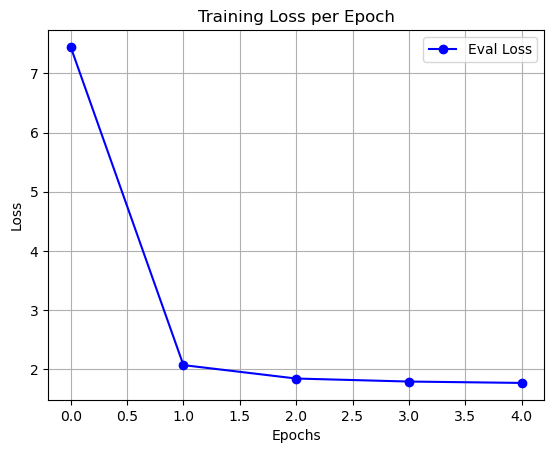

In [25]:
import matplotlib.pyplot as plt
import json

# Load the JSON file
with open("/home/gdlteam3/AraT5/arat5-finetuned/checkpoint-2500/trainer_state.json", "r", encoding="utf-8") as f:
    train_state = json.load(f)

# Extract all eval_loss values from log_history
losses = [
    entry["loss"]
    for entry in train_state.get("log_history", [])
    if "loss" in entry
]

# Plotting
plt.plot(eval_losses, marker='o', color='b', label='Eval Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()

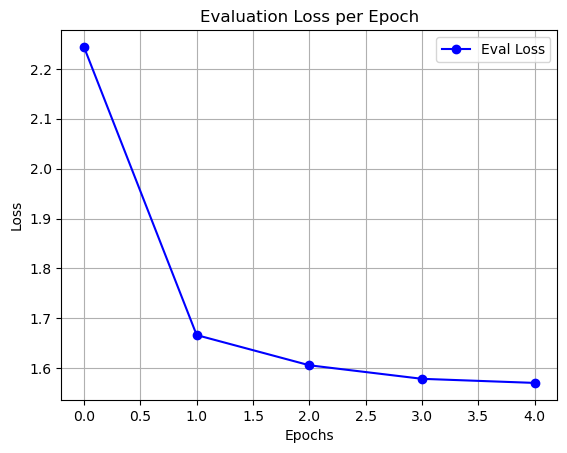

In [26]:
import matplotlib.pyplot as plt
import json

# Load the JSON file
with open("/home/gdlteam3/AraT5/arat5-finetuned/checkpoint-2500/trainer_state.json", "r", encoding="utf-8") as f:
    train_state = json.load(f)

# Extract all eval_loss values from log_history
eval_losses = [
    entry["eval_loss"]
    for entry in train_state.get("log_history", [])
    if "eval_loss" in entry
]

# Plotting
plt.plot(eval_losses, marker='o', color='b', label='Eval Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Evaluation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.show()


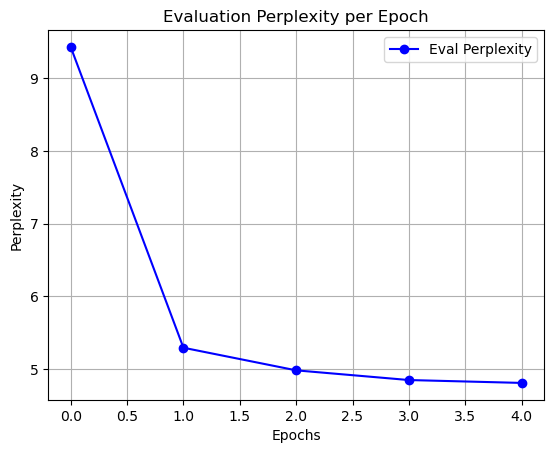

In [27]:
import math

perplexities = [math.exp(loss) for loss in eval_losses]

# Plotting
plt.plot(perplexities, marker='o', color='b', label='Eval Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.title('Evaluation Perplexity per Epoch')
plt.legend()
plt.grid(True)
plt.show()